In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from flowFieldWavy import *
from flowFieldArray import *
from pseudo import *
from laminar import *
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

figureFolder = '/home/sabarish/Dropbox/reports/2016/JFM/figures/'




In [ ]:
# Exact solutions to compare with low wavenumber analytical solution

flowDict = getDefaultDict()
Re = 100.
flowDict.update({'eps':0.005,'alpha':1.,'beta':0.,'Re':Re,'L':5,'M':0,'N':30,'nd':4, 'isPois':1})

savePath = 'solutions/Re0p1/'
epsArr = 0.5*np.arange(0.025,0.152,0.025)
aArr = 10.**(np.arange(-2.,1.01,0.2))

vfListRe100 = []; pfListRe100 = []; fnormListRe100 = []; flagListRe100 = []
flowDict.update({'eps':np.float(epsArr[0]),'alpha':np.float(aArr[0])})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
start = time.time()
for eps in epsArr:
    vf.flowDict.update({'eps':np.float(eps)})
    pf.flowDict.update({'eps':np.float(eps)})
    for a in aArr:
        vf.flowDict.update({'alpha':np.float(a)})
        pf.flowDict.update({'alpha':np.float(a)})
        
        start1 = time.time()
        print('eps:%f, a:%f, gx:%f, Re:%f'%(eps,a,eps*a,vf.flowDict['Re']))
        vf,pf,fnormArr,flg = iterate(vf=vf, pf=pf,tol=1.0e-12)
        vfListRe100.append(vf.copy())
        pfListRe100.append(pf.copy())
        fnormListRe100.append(fnormArr.copy())
        flagListRe100.append(flg)
        
        print('Runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))
        print('**************************************')

In [54]:
# Loading solution files for amplitude-slope parametric range at Re of either 10, 100, or 1000
Re = 10.
loadPath = 'solutions/Re'+ str(int(Re))+'/'
files= [f for f in os.listdir(loadPath)]
files.sort()

epsArr = np.zeros((20,30)).flatten()
aArr = epsArr.copy()
gArr = epsArr.copy()
vList = []; pList = []
k = 0
for f in files:
    vf,pf = loadff(loadPath+f)
    vList.append(vf); pList.append(pf)
    eps = vf.flowDict['eps']
    a = vf.flowDict['alpha']
    g = eps*a
    epsArr[k] = eps
    gArr[k] = g
    aArr[k] = a
    k+= 1
    
epsArr = epsArr.reshape((20,30))
gArr= gArr.reshape((20,30))

neps = epsArr.shape[0]; ng = epsArr.shape[1]; nRe = 1
vArr = flowFieldArray(vList,neps,ng,nRe); pArr = flowFieldArray(pList,neps,ng,nRe)

In [55]:
# Calculating vCL_RMS, xSep, xReat, yBub, vFlux, and pDrag for each flowField in vArr,pArr
pDrag = np.zeros(epsArr.shape)
xSep = pDrag.copy(); xReat = pDrag.copy(); xBub = pDrag.copy(); yBub = pDrag.copy()
vFlux = pDrag.copy()
vCore = pDrag.copy()

for k1 in range(neps):
    for k2 in range(ng):
        vf = vArr[k1,k2,0].field
        pf = pArr[k1,k2,0].field
        pDrag[k1,k2] = presDrag(pf)[0]
        shearDict = shearStress(vf, seprn=True)
        xSep[k1,k2] = shearDict['xSep']
        xReat[k1,k2] = shearDict['xReat']
        yBub[k1,k2] = shearDict['yBub']
        if xSep[k1,k2] is not None:
            xBub[k1,k2] = xReat[k1,k2] - xSep[k1,k2]
        else:
            xBub[k1,k2] = None
        
        vFlux[k1,k2] = vf.flux()
        vCore[k1,k2] = vCL_RMS(vf)


epsVec = epsArr[:,0]; gVec = gArr[0,:]   

In [56]:
xSep[np.isnan(xSep)] = 0.50001
xReat[np.isnan(xReat)] = 0.49999
yBub[np.isnan(yBub)] = -0.00001
xBub = xReat - xSep


vArrRe10 = vArr.copy(); pArrRe10 = pArr.copy()
pDragRe10 = pDrag.copy(); vFluxRe10 = vFlux.copy(); vCoreRe10 = vCore.copy()
xSepRe10 = xSep.copy(); xReatRe10 = xReat.copy(); xBubRe10 = xBub.copy(); yBubRe10 = yBub.copy()

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


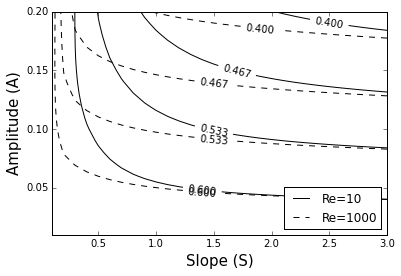

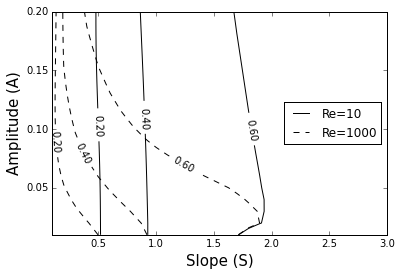

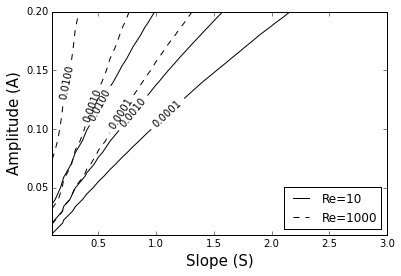

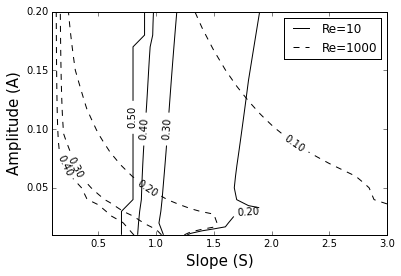

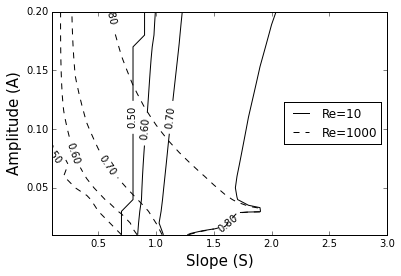

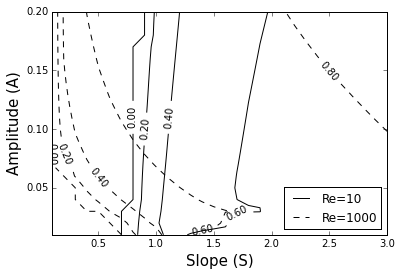

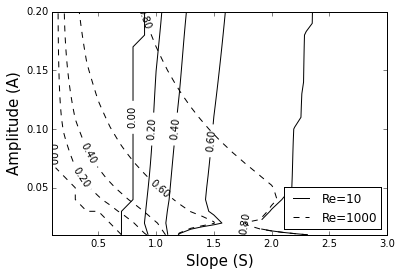

In [67]:
plt.figure()
# vFlux
vFluxLevels = 1./3.*np.arange(1.0,2.1,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe10,levels=vFluxLevels,colors='k')
plt.clabel(C10,fmt='%0.3f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe1000, levels=vFluxLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.3f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vFlux.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vFlux.eps",dpi=600,format="eps")
plt.show()

plt.figure()
#pDrag
pDragLevels = np.arange(0.2,0.85,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, pDragRe10,levels=pDragLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, pDragRe1000,levels=pDragLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='center right')
plt.savefig(figureFolder+'noLabels/'+"pDrag.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"pDrag.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# vCore
vCoreLevels= [0.0001,0.001,0.01]
C10 = plt.contour(2.*gArr, 2.*epsArr, vCoreRe10,levels=vCoreLevels,colors='k')
plt.clabel(C10,fmt='%0.4f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, vCoreRe1000, levels=vCoreLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.4f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vCore.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vCore.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# xSep
xSepLevels = np.arange(0.1,0.55,0.1)
C10 = plt.contour(2.*gArr, 2.*epsArr, xSepRe10,levels=xSepLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, xSepRe1000,levels=xSepLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='upper right')
plt.savefig(figureFolder+'noLabels/'+"xSep.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"xSep.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# xReat
xReatLevels = np.arange(0.5,0.95,0.1)
C10 = plt.contour(2.*gArr, 2.*epsArr, xReatRe10,levels=xReatLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, xReatRe1000,levels=xReatLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='center right')
plt.savefig(figureFolder+'noLabels/'+"xReat.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"xReat.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# xBub
xBubLevels = np.arange(0.,1.1,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, xBubRe10,levels=xBubLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, xBubRe1000,levels=xBubLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"xBub.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"xBub.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# yBub
yBubLevels = np.arange(0.,0.81,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, yBubRe10,levels=yBubLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe1000,levels=yBubLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"yBub.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"yBub.eps",dpi=600,format="eps")
plt.show()


/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


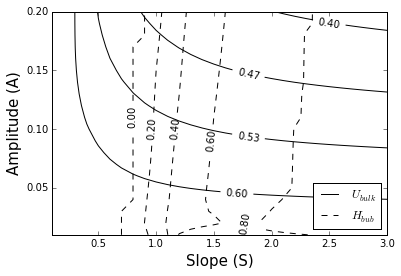

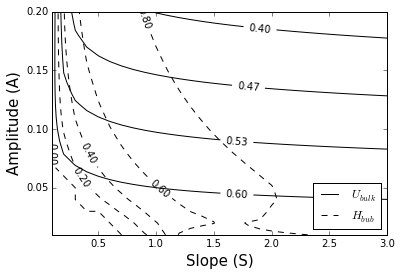

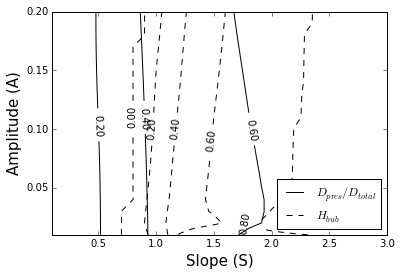

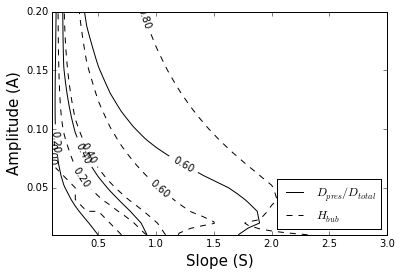

In [66]:
plt.figure()
# vFlux-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe10,levels=vFluxLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe10, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$U_{bulk}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vFluxYbubRe10.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vFluxYbubRe10.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# vFlux-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe1000,levels=vFluxLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe1000, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$U_{bulk}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vFluxYbubRe1000.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vFluxYbubRe1000.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# pDrag-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, pDragRe10,levels=pDragLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe10, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$D_{pres}/D_{total}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"pDragYbubRe10.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"pDragYbubRe10.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# pDrag-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, pDragRe1000,levels=pDragLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe1000, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$D_{pres}/D_{total}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"pDragYbubRe1000.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"pDragYbubRe1000.eps",dpi=600,format="eps")
plt.show()

In [26]:
xBub[:, 7:9]

array([[ 0.      ,  0.      ],
       [ 0.111642,  0.296109],
       [ 0.080471,  0.286238],
       [      nan,  0.274846],
       [      nan,  0.261341],
       [      nan,  0.246931],
       [      nan,  0.231825],
       [      nan,  0.216737],
       [      nan,  0.202403],
       [      nan,  0.189135],
       [      nan,  0.176853],
       [      nan,  0.165288],
       [      nan,  0.154093],
       [      nan,  0.142853],
       [      nan,  0.130988],
       [      nan,  0.11739 ],
       [      nan,  0.098051],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan]])

In [ ]:
flowDict = getDefaultDict()
flowDict.update({'K':0,'L':5,'M':0,'N':11,'Re':0.01,'alpha':0.01,'beta':0.,'eps':0.1,'isPois':1})

In [ ]:
vf,pf,fnormArr,flg = iterate(flowDict=flowDict, rect=False,tol = 1.0e-13,iterMax=10)

In [ ]:
vfAn = vf.zero()
a = vf.flowDict['alpha']; eps = vf.flowDict['eps']; g=eps*a
vfAn[0,vf.nx//2,0,0] = 1.-vfAn.y**2
vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2+2,0,0] = 2.*g**2 * (1.-vfAn.y**2)
vfAn[0,vf.nx//2-1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2-2,0,0] = 2.*g**2 * (1.-vfAn.y**2)

vfAn[0,vf.nx//2,0,0] = 0.
vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2+2,0,0] = 2.*g**2 * (1.-vfAn.y**2)
vfAn[0,vf.nx//2-1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2-2,0,0] = 2.*g**2 * (1.-vfAn.y**2)



In [ ]:
chebcoeffs(vf[0,vf.nx//2,0,0]),chebcoeffs(vf[0,vf.nx//2+1,0,0]),chebcoeffs(vf[0,vf.nx//2+2,0,0])

In [ ]:
chebcoeffs(vf[0,3,0,1]),chebcoeffs(vf[0,4,0,1]),chebcoeffs(vf[0,5,0,1])

In [ ]:
chebcoeffs(pf[0,3,0,0]),chebcoeffs(pf[0,4,0,0]),chebcoeffs(pf[0,5,0,0]), chebcoeffs(pf[0,2,0,0])

In [ ]:
pf[0,2,0,0,-1], pf[0,4,0,0,-1]

In [ ]:
flowDict = vf.flowDict.copy()
flowDict.update({'L':3,'M':0,'N':7,'Re':1.,'alpha':0.1,'beta':0.,'eps':0.01})

In [ ]:
vf,pf,fnormArr,flg = iterate(flowDict=flowDict, rect=False,tol = 1.0e-13,iterMax=10)

In [ ]:
chebcoeffs(vf[0,3,0,0]),chebcoeffs(vf[0,4,0,0]),chebcoeffs(vf[0,5,0,0])

In [ ]:
chebcoeffs(vf[0,3,0,1]),chebcoeffs(vf[0,4,0,1]),chebcoeffs(vf[0,5,0,1])

In [ ]:
chebcoeffs(pf[0,3,0,0]),chebcoeffs(pf[0,4,0,0]),chebcoeffs(pf[0,5,0,0])

In [ ]:
pf[0,5,0,0]

In [ ]:
flowDict = vf.flowDict.copy()
flowDict.update({'L':6,'M':0,'N':35,'Re':10.,'alpha':10.,'beta':0.,'eps':0.05})
vf,pf,fnormArr,flg = iterate(flowDict=flowDict, rect=False,tol = 1.0e-13,iterMax=10)

In [ ]:
(vf[0,8,0,0] - vf[0,8,0,0,::-1])

In [ ]:
w = clencurt(vf.N)
vf[0,vf.nx//2+2,0,0],np.dot(w,vf[0,vf.nx//2+2,0,0])

In [ ]:
vf.div()

In [ ]:
import os 
files= [f for f in os.listdir('./solutions/Re0p1/')]
files.sort()
loadPath = 'solutions/Re0p1/'

In [ ]:
neps = 20;ng=19;nRe=1
Re = 0.1
uDistArr = np.zeros(neps*ng)
pDistArr = uDistArr.copy()
n=0
for f in files:
    vf,pf = loadff(loadPath+f,checkNorm=False)

    vfAn = vf.zero(); pfAn = pf.zero()
    a = vf.flowDict['alpha']; eps = vf.flowDict['eps']; g=eps*a
    vfAn[0,vf.nx//2,0,0] = 1.-vfAn.y**2
    vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
    vfAn[0,vf.nx//2-1,0,0] = vfAn[0,vf.nx//2+1,0,0]
    
    vfAn[0,vf.nx//2+1,0,1] = 1.j*g*(1.-vfAn.y*2)
    vfAn[0,vf.nx//2+2,0,1] = 2.j/3.*g**2*a*(vfAn.y**3 - vfAn.y)
    vfAn[0,vf.nx//2-1,0,1] = -vfAn[0,vf.nx//2+1,0,1]
    vfAn[0,vf.nx//2-2,0,1] = -vfAn[0,vf.nx//2+2,0,1]
    
    pfAn[0,pf.nx//2+1,0,0] = -2.j*g/Re*pfAn.y
    pfAn[0,pf.nx//2+2,0,0] = -2.j*g*a/Re
    pfAn[0,pf.nx//2-1,0,0] = -pfAn[0,pf.nx//2+1,0,0]
    pfAn[0,pf.nx//2-2,0,0] = -pfAn[0,pf.nx//2+2,0,0]
    
    uDistArr[n] = (vf-vfAn).norm()/vf.norm() 
    pDistArr[n] = (pf-pfAn).norm()/pf.norm()
    print(eps,a,uDistArr[n],pDistArr[n])
    n+= 1


In [ ]:
flowDict = getDefaultDict()
aArr = np.arange(0.005,0.052,0.005,dtype=np.float)
epsArr = np.arange(0.005,0.052,0.005)
Re = 0.1
flowDict.update({'eps':epsArr[0],'alpha':aArr[0],'beta':0.,'Re':Re,'L':5,'M':0,'N':20,'nd':4, 'isPois':1})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()

neps = epsArr.size; na = aArr.size
uDistArr = np.zeros(neps*na); pDistArr = uDistArr.copy()

ind=0
for eps in epsArr:
    for a in aArr:
        vf.flowDict.update({'eps':eps,'alpha':a})
        pf.flowDict.update({'eps':eps,'alpha':a})
        g = eps*a
        
        vf, pf, fnormArr, flg = iterate(vf=vf,pf=pf,rect=False, tol=1.0e-12 )

        vfAn = vf.zero(); pfAn = pf.zero()
        vfAn[0,vf.nx//2,0,0] = 1.-vfAn.y**2
        vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
        vfAn[0,vf.nx//2-1,0,0] = vfAn[0,vf.nx//2+1,0,0]

        vfAn[0,vf.nx//2+1,0,1] = 1.j*g*(1.-vfAn.y*2)
        vfAn[0,vf.nx//2+2,0,1] = 2.j/3.*g**2*a*(vfAn.y**3 - vfAn.y)
        vfAn[0,vf.nx//2-1,0,1] = -vfAn[0,vf.nx//2+1,0,1]
        vfAn[0,vf.nx//2-2,0,1] = -vfAn[0,vf.nx//2+2,0,1]

        pfAn[0,pf.nx//2+1,0,0] = -2.j*g/Re*pfAn.y
        pfAn[0,pf.nx//2+2,0,0] = -2.j*g*a/Re
        pfAn[0,pf.nx//2-1,0,0] = -pfAn[0,pf.nx//2+1,0,0]
        pfAn[0,pf.nx//2-2,0,0] = -pfAn[0,pf.nx//2+2,0,0]

        uDistArr[ind] = (vf-vfAn).norm()/vf.norm() 
        pDistArr[ind] = (pf-pfAn).norm()/pf.norm()
        print(eps,a,uDistArr[ind],pDistArr[ind])        
        ind+=1



In [ ]:
flowDict = updateDict(vf.flowDict,{'L':6,'M':0,'N':50,'eps':0.02,'alpha':30.,'beta':0.,'Re':100.})
vf,pf,fnorm,flg = iterate(flowDict=flowDict,rect=False,tol=1.0e-12)


In [ ]:
vf.shape,pf.shape,vf.nz,pf.nz

In [ ]:
presDrag(pf)

In [ ]:
stressDict = shearStress(vf,seprn=True)

In [ ]:
presDrag(pf)[0] + stressDict['avgStressFraction']

In [ ]:
type(genArr[0]) == np.float

In [ ]:
plt.contourf(epsArr,aArr,np.log(uDistArr.reshape((neps,na))),cmap=plt.cm.bone ) 
plt.xticks(np.arange(0.01,0.055,0.01))
plt.yticks(np.arange(0.01,0.055,0.01))
plt.colorbar();plt.show()

In [ ]:
np.log(uDistArr)

In [ ]:
y = vf.y

In [ ]:
genFun = 1.*y**3 + 4.*y**2 + y  - y**4

In [ ]:
np.arange(y.size)[genFun<=0]

In [ ]:
genFun

## High wavenumber asymptote

In [227]:
import sys
eps = 0.05; Re = 1000.
gArr = 0.5*np.arange(12.,19.9,1.)

aArr = gArr/eps
flowDict = getDefaultDict()
flowDict.update({'eps':eps,'beta':0.,'Re':Re,'isPois':1,'L':8,'M':0,'N':75,'nd':3})
flowDict.update({'alpha':aArr[0]})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()
vfList = []; pfList=[]

for k in range(aArr.size):
    a = aArr[k] 
    vf.flowDict.update({'alpha':a}); pf.flowDict.update({'alpha':a}) 
    vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax = 8,tol=5.0e-11)
    print('alpha:',a, '  flag:',flg)
    sys.stdout.flush()
    vfList.append(vf.copy())
    pfList.append(pf.copy())
    saveff(vf,pf,prefix='solutions/highAlpha/N75/')
    sys.stdout.flush()
    
    
    

Converged in  4  iterations. Returning....................................
alpha: 120.0   flag: 0
saved to  solutions/highAlpha/N75/T00E0500Gx6000Gz0000Re1000L08M00N75
Converged in  2  iterations. Returning....................................
alpha: 130.0   flag: 0
saved to  solutions/highAlpha/N75/T00E0500Gx6500Gz0000Re1000L08M00N75
Converged in  2  iterations. Returning....................................
alpha: 140.0   flag: 0
saved to  solutions/highAlpha/N75/T00E0500Gx7000Gz0000Re1000L08M00N75
Converged in  2  iterations. Returning....................................
alpha: 150.0   flag: 0
saved to  solutions/highAlpha/N75/T00E0500Gx7500Gz0000Re1000L08M00N75
Converged in  2  iterations. Returning....................................
alpha: 160.0   flag: 0
saved to  solutions/highAlpha/N75/T00E0500Gx8000Gz0000Re1000L08M00N75
Converged in  2  iterations. Returning....................................
alpha: 170.0   flag: 0
saved to  solutions/highAlpha/N75/T00E0500Gx8500Gz0000Re1000L0

In [ ]:
vfListRe1000 = vfList.copy(); pfListRe1000 = pfList.copy()

vfListRe10 = []; pfListRe10 = []

for k in range(len(vfList)):
    vf = vfList[k].copy(); pf = pfList[k].copy()
    vf.flowDict.update({'Re':10.}); pf.flowDict.update({'Re':10.})
    vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax = 8,tol=1.0e-12)
    print('alpha:',vf.flowDict['alpha'], '  flag:',flg)
    sys.stdout.flush()
    vfListRe10.append(vf.copy())
    pfListRe10.append(pf.copy())
    saveff(vf,pf,prefix='solutions/highAlpha/')
    sys.stdout.flush()

In [8]:
vfListFine = []; pfListFine = []
loadPathFine = 'solutions/highAlpha/L08N75/'
files = os.listdir(loadPathFine)
files.sort()
for f in files:
    vf, pf = loadff(loadPathFine+f)
    vfListFine.append(vf.copy())
    pfListFine.append(pf.copy())
vfArrFine = flowFieldArray(vfListFine, 1,len(vfListFine),1)
pfArrFine = flowFieldArray(pfListFine, 1,len(vfListFine),1)

In [7]:
loadPath = 'solutions/highAlpha/'
files = os.listdir(loadPath)
files.sort()
vfList = []; pfList = []
for f in files:
    #print(loadPath+f)
    if not os.path.isdir(loadPath+f):
        vf,pf = loadff(loadPath+f)
        vfList.append(vf); pfList.append(pf)

vfArr = flowFieldArray(vfList, 1,len(vfList)//2,2)
pfArr = flowFieldArray(pfList, 1,len(pfList)//2,2)

In [295]:
%debug

> /home/sabarish/Dropbox/gitwork/python3/flowFieldV2/flowFieldWavy.py(234)name2dict()
    233     flowDict['M'] = int(fName[-5:-3])
--> 234     flowDict['L'] = int(fName[-8:-6])
    235     flowDict['Re'] = np.float64(fName[-13:-9])

ipdb> fName
'solutions/highAlpha/L08N75'
ipdb> exit


In [28]:
vfListFiner = []; pfListFiner = []
loadPathFiner = 'solutions/highAlpha/L11N75/'
files = os.listdir(loadPathFiner)
files.sort()
for f in files:
    vf, pf = loadff(loadPathFiner+f)
    vfListFiner.append(vf.copy())
    pfListFiner.append(pf.copy())
vfArrFiner = flowFieldArray(vfListFiner, 1,len(vfListFiner),1)
pfArrFiner = flowFieldArray(pfListFiner, 1,len(vfListFiner),1)

In [10]:
uBulkArr = vfArr.getProperty('flux')
gArr = vfArr.getProperty('g')
gVec = gArr[0,:,0]

In [11]:
uBulkArrFine = vfArrFine.getProperty('flux')
gArrFine = vfArrFine.getProperty('g')
gVecFine = gArrFine[0,:,0]

In [29]:
uBulkArrFiner = vfArrFiner.getProperty('flux')
gArrFiner = vfArrFiner.getProperty('g')
gVecFiner = gArrFiner[0,:,0]

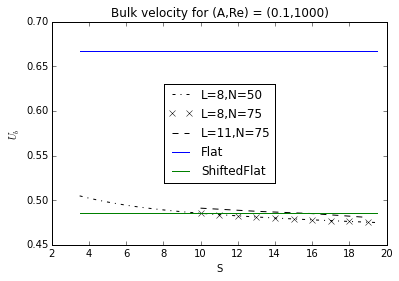

In [31]:
#plt.plot(2.*gVec,uBulkArr[0,:,0],'k-.') # Re=10
plt.plot(2.*gVec,uBulkArr[0,:,1],'k-.') # Re=1000
plt.plot(2.*gVecFine,uBulkArrFine[0,:,0],'kx') # Re=1000
plt.plot(2.*gVecFiner,uBulkArrFiner[0,:,0],'k--') # Re=1000
plt.plot(2.*gVec, 2./3.*np.ones(gVec.size) )
plt.plot(2.*gVec, 2./3.*(0.9**3)*np.ones(gVec.size) )
plt.legend(['L=8,N=50','L=8,N=75','L=11,N=75','Flat','ShiftedFlat'],loc='center')
#uBulkAsym = 2./3.*(1.-2.*tempDict['eps'])**2
plt.ylim([0.45,0.7])
plt.xlabel('S'); plt.ylabel('$U_b$')
plt.title('Bulk velocity for (A,Re) = (0.1,1000)' )
plt.savefig('highSlopeAsym.eps',dpi=1200,format='eps')
plt.show()

In [27]:
uBulkArrFiner

array([[[ 0.49102592],
        [ 0.48752878],
        [ 0.48497031],
        [ 0.48063543],
        [ 0.4830531 ],
        [ 0.47402261],
        [ 0.48176249]]])

In [260]:
#vf = vfArrFine[0,-1,0].field.copy(); pf = pfArr[0,-1,0].field.copy() 

#vf.flowDict.update({'alpha':2000.}); pf.flowDict.update({'alpha':2000.})
vf = vf.slice(L=18,N=75); pf=pf.slice(L=18,N=75)
vf[:,:,:,:,[0,-1]] = 0.
vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax=5,tol=1.0e-11)
saveff(vf,pf)

Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx9500Gz0000Re1000L18M00N75


In [262]:
vf.flux(), vf.flowDict, vfFinest.flux(), vfFinest.flowDict

(array([ 0.48176249]),
 {'K': 0,
  'L': 18,
  'M': 0,
  'N': 75,
  'Re': 1000.0,
  'alpha': 190.0,
  'beta': 0.0,
  'eps': 0.050000000000000003,
  'isPois': 1,
  'lOffset': 0.0,
  'mOffset': 0.0,
  'nd': 3,
  'noise': 0.0,
  'omega': 0.0},
 array([ 0.4830531]),
 {'K': 0,
  'L': 14,
  'M': 0,
  'N': 75,
  'Re': 1000.0,
  'alpha': 190.0,
  'beta': 0.0,
  'eps': 0.050000000000000003,
  'isPois': 1,
  'lOffset': 0.0,
  'mOffset': 0.0,
  'nd': 3,
  'noise': 0.0,
  'omega': 0.0})

In [250]:
for g in [5.,6.5,8.]:
    a = g/vf.flowDict['eps']
    vf.flowDict.update({'alpha':a}); pf.flowDict.update({'alpha':a})
    vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax=6,tol=1.0e-11)
    saveff(vf,pf)
    
    

Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx5000Gz0000Re1000L14M00N75
Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx6500Gz0000Re1000L14M00N75
Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx8000Gz0000Re1000L14M00N75


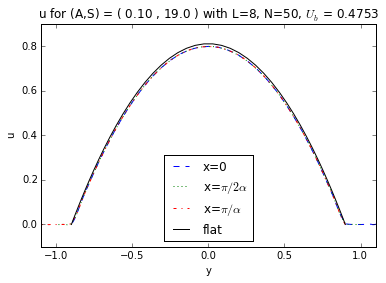

0.05 190.0


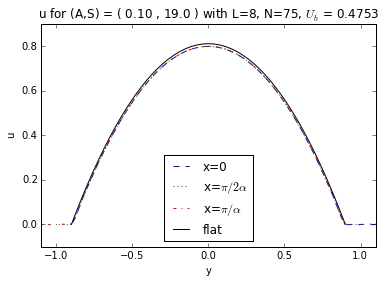

0.05 190.0


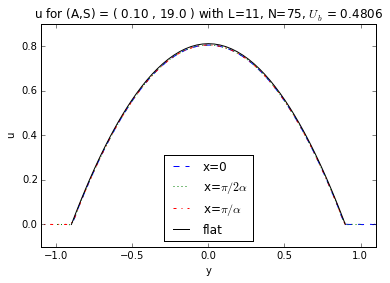

0.05 190.0


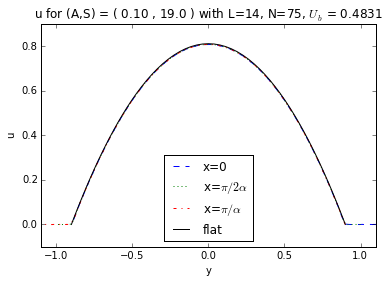

0.05 190.0


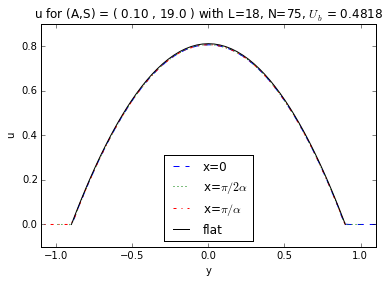

In [266]:
vfCoarse = vfArr[0,-2,-1].field.copy()
vfFine = vfArrFine[0,-1,-1].field.copy()

tempDict = vfFine.flowDict.copy(); tempDict.update({'L':11,'N':75})
vf,pf = loadff(dict2name(tempDict))
vfFiner = vf.copy()

tempDict.update({'L':14})
vf,pf = loadff(dict2name(tempDict))
vfFinest = vf.copy()

tempDict.update({'L':18})
vf,pf = loadff(dict2name(tempDict))
vfFinestest = vf.copy()

vf = vfCoarse
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
eps = vf.flowDict['eps']; a= vf.flowDict['alpha']; g = eps*a
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5coarse.eps',dpi=1200,format='eps')
plt.show()

vf = vfFine
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5fine.eps',dpi=1200,format='eps')
plt.show()

vf = vfFiner
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5finer.eps',dpi=1200,format='eps')
plt.show()


vf = vfFinest
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5finest.eps',dpi=1200,format='eps')
plt.show()


vf = vfFinestest
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5finestest.eps',dpi=1200,format='eps')
plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


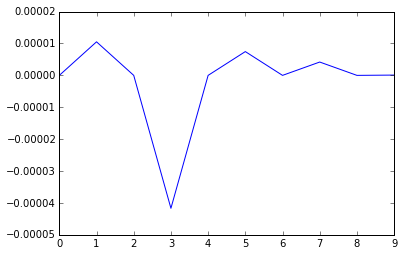

array([  1.27156205e-07,   1.28247961e-07,   1.30432846e-07,
         1.33707865e-07,   1.38056629e-07,   1.43443458e-07,
         1.49820602e-07,   1.57165542e-07,   1.65567960e-07,
         1.75381013e-07,   1.87429352e-07,   2.03213536e-07,
         2.24962408e-07,   2.55288033e-07,   2.96185715e-07,
         3.47376064e-07,   4.04683670e-07,   4.60108352e-07,
         5.05361656e-07,   5.37884164e-07,   5.61957444e-07,
         5.72375293e-07,   5.16300969e-07,   2.59460276e-07,
         3.80832688e-07,   1.48434330e-06,   2.81319411e-06,
         3.73776943e-06,   3.52176191e-06,   1.91000947e-06,
         4.53177426e-07,   2.28350514e-06,   2.62595040e-06,
         1.62292218e-06,   3.55683042e-07,   2.07472783e-07,
         6.21852623e-08])

In [293]:
for l in range(18,19):
    plt.plot(uCoeffs[l,-10:]/np.sum(np.abs(uCoeffs[l])) )
plt.show()
np.abs(uCoeffs[35,1::2])

(array([ 0.48176249]), 0.3911064085323771)

In [255]:
uArr = vfFinest.getScalar().ifft(xLoc=2.,zLoc=0.)
weights = clencurt(vf.N)
0.5*np.dot(weights,uArr.flatten()), 2./3.*(1.-2.*vf.flowDict['eps'])**3

(0.48305310328688489, 0.48600000000000004)

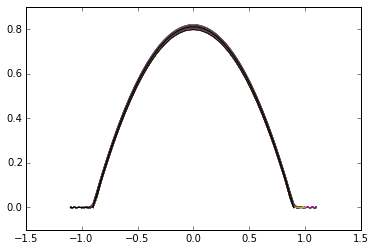

In [223]:
for k in range(5,vfArr.shape[1]):
    vf = vfArr[0,k,1].field
    u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
    u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
    u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
    plt.plot(0.1+vf.y,u0.flatten())
    plt.plot(vf.y,u1.flatten())
    plt.plot(-0.1+vf.y,u2.flatten())
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')

plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


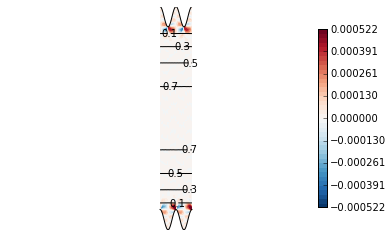

In [224]:
figHeight = 3. # Inches
vLim = [-0.06,0.06]; nvLevels = 50
vNegLevels = np.arange(-0.06,0.,0.01)
uLevels = np.arange(0.1,0.75,0.2)
cTicks = np.arange(-0.06,0.065,0.02)
nx = 40

a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']
X = np.tile( np.arange(0.,2*Lx+Lx/nx/2., Lx/nx).reshape((1,2*nx+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(a*X)

figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T

#V[V>vLim[-1]] = vLim[-1]*0.999999
#V[V<vLim[0]] = vLim[0]
#dvLim = (vLim[-1]-vLim[0])/nvLevels
#cLevels = np.arange(vLim[0],vLim[-1]+dvLim/2., dvLim)


#plt.figure(figsize=(20*figWidth,figHeight))
plt.plot(50.*X[0],Y[0],'k')
plt.plot(50.*X[-1],Y[-1],'k')

vmax = np.max(np.max(V))
vmin = -vmax

# filled contours for V
plt.contourf(50.*X,Y,V, levels=np.arange(vmin,1.001*vmax,0.05*vmax),cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20, ticks=np.arange(vmin,1.001*vmax,0.25*vmax))
#plt.clim(vLim)
#plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off'); plt.axis('equal')

# line contours for negative values of V
#plt.contour(50.*X,Y,V, colors='k',levels=vNegLevels)

# Line contours for U
uctr = plt.contour(50.*X,Y,U, colors='k', levels = uLevels)
plt.clabel(uctr,fmt='%0.1f',fontsize='x-large')

plt.margins(x=0)
plt.show()


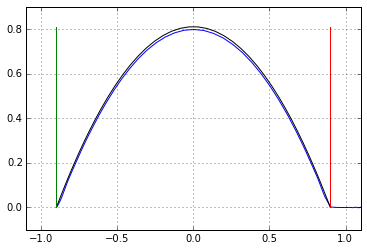

ValueError: shapes (65,) and (50,) not aligned: 65 (dim 0) != 50 (dim 0)

In [225]:
#for k in [0,5,10,15,20,25]:
for k in [0]:
    plt.plot(Y[:,k],U[:,k])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.xlim([-1.1,1.1]); plt.grid(); 
plt.plot(-0.9*np.ones(yNew.size), uNew)
plt.plot(0.9*np.ones(yNew.size), uNew)
plt.show()
print(np.dot(weights,U[:,k])*0.5, 2./3.*0.9**3)

plt.figure()
for k in [0,5,10,15,20,25]:
    plt.plot(Y[:,k],V[:,k])
#yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
#plt.plot(yNew,uNew,'k')
plt.xlim([-1.1,1.1]); plt.grid(); 
#plt.plot(-0.9*np.ones(yNew.size), uNew)
#plt.plot(0.9*np.ones(yNew.size), uNew)
plt.show()



## Analytical solution vs numerical solutions
Plot bulk velocity, and the distance of velocity fields. 

In [ ]:
uBulkArr = np.zeros((6,16)); pDragArr = uBulkArr.copy(); ReArr = uBulkArr.copy()
k = 0
for k1 in range(epsArr.size):
    for k2 in range(aArr.size):
        vf = vfListRe100[k]; pf = pfListRe100[k]
        uBulkArr[k1,k2] = vf.flux()
        pDragArr[k1,k2] = presDrag(pf)[0]
        ReArr[k1,k2] = vf.flowDict['Re']
        k+= 1
uBulkArr100 = uBulkArr.copy(); pDragArr100 = pDragArr.copy(); ReArr100 = ReArr.copy()

In [ ]:
markers = ['x','+','o','v','s','d']
print('Re:',ReArr100)



plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (3./2.*uBulkArr100[k1]-1.)
    plt.scatter(gArr,  psi , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, -4.*gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=3)
plt.savefig(figureFolder+'noLabels/'+'psiRe100.eps',format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$\\psi$',fontsize=15)
plt.savefig(figureFolder+'psiRe100.eps',format='eps',dpi=1200)
plt.show()

#*****************************************************************
#pressure drag
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (3./2.*uBulkArr[k1]-1.)
    plt.scatter(gArr,  pDragArr100[k1] , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.savefig(figureFolder+'noLabels/'+'pDragRe100.eps',format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$D_{pres}/D_{total}$',fontsize=15)
plt.savefig(figureFolder+'pDragRe100.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
markers = ['x','+','o','v','s','d']
print('Re:',ReArr0p1)



plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (3./2.*uBulkArr0p1[k1]-1.)
    plt.scatter(gArr,  psi , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, -4.*gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=3)
plt.savefig(figureFolder+'noLabels/'+'psiRe0p1.eps',format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$\\psi$',fontsize=15)
plt.savefig(figureFolder+'psiRe0p1.eps',format='eps',dpi=1200)
plt.show()

#*****************************************************************
#pressure drag
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    plt.scatter(gArr,  pDragArr0p1[k1] , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.savefig(figureFolder+'noLabels/'+'pDragRe0p1.eps',format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$D_{pres}/D_{total}$',fontsize=15)
plt.savefig(figureFolder+'pDragRe0p1.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
markers = ['x','+','o','v','s','d']


plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (3./2.*uBulkArr100[k1]-1.)
    plt.scatter(aArr,  (-4.*gArr**2 - psi)/psi, marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,9.])
plt.savefig(figureFolder+'noLabels/'+'psiRelErrRe100.eps',format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$\\psi_{rel-err}$',fontsize=15)
plt.savefig(figureFolder+'psiRelErrRe100.eps',format='eps',dpi=1200)
plt.show()

################################
# pressure drag, relative error
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    plt.scatter(aArr,  (2.*gArr**2 - pDragArr100[k1])/pDragArr100[k1], marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,2.])
plt.savefig(figureFolder+'noLabels/'+'pDragRelErrRe100.eps',format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$D_{pres,rel-err}$',fontsize=15)
plt.savefig(figureFolder+'pDragRelErrRe100.eps',format='eps',dpi=1200)
plt.show()

In [ ]:
markers = ['x','+','o','v','s','d']


plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (3./2.*uBulkArr0p1[k1]-1.)
    plt.scatter(aArr,  (-4.*gArr**2 - psi)/psi, marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,9.])
plt.savefig(figureFolder+'noLabels/'+'psiRelErrRe0p1.eps',format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$\\psi_{rel-err}$',fontsize=15)
plt.savefig(figureFolder+'psiRelErrRe0p1.eps',format='eps',dpi=1200)
plt.show()

################################
# pressure drag, relative error
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    plt.scatter(aArr,  (2.*gArr**2 - pDragArr0p1[k1])/pDragArr0p1[k1], marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,2.])
plt.savefig(figureFolder+'noLabels/'+'pDragRelErrRe0p1.eps',format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$D_{pres,rel-err}$',fontsize=15)
plt.savefig(figureFolder+'pDragRelErrRe0p1.eps',format='eps',dpi=1200)
plt.show()

## Local shear stress distribution 

In [102]:
flowDict = getDefaultDict()
flowDict.update({'eps':0.05,'beta':0.,'Re':10.,'isPois':1,'L':8,'M':0,'N':50})

flowDict.update({'alpha':5.})
vfLow,pfLow = loadff(dict2name(flowDict,prefix='solutions/Re10/'))

flowDict.update({'alpha':18.})
vfHigh,pfHigh = loadff(dict2name(flowDict,prefix='solutions/Re10/'))


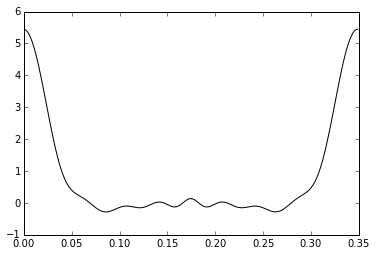

In [116]:
tempDict = shearDictHigh.copy(); a = vfHigh.flowDict['alpha']
funTest = tempDict['strainRateFun']
Lx = 2.*np.pi/a
xTest = np.arange(0.,Lx*1.001,0.005*Lx)
plt.plot(xTest, funTest(xTest),'k'); plt.show()

### Velocity contours 

In [127]:
flowDict = getDefaultDict()
flowDict.update({'eps':0.1,'beta':0.,'Re':100.,'isPois':1,'L':8,'M':0,'N':50})

flowDict.update({'alpha':1.5})
vfLow,pfLow = loadff(dict2name(flowDict,prefix='solutions/Re100/'))

flowDict.update({'alpha':4.})
vfMid,pfMid = loadff(dict2name(flowDict,prefix='solutions/Re100/'))

flowDict.update({'alpha':12.})
vfHigh,pfHigh = loadff(dict2name(flowDict,prefix='solutions/Re100/'))

In [ ]:
from matplotlib.colorbar import make_axes
vf = vfHigh; fName = 'uvContoursHigh'
figHeight = 3. # Inches
vLim = [-0.06,0.06]; nvLevels = 50
vNegLevels = np.arange(-0.06,0.,0.01)
uLevels = np.arange(0.1,0.75,0.2)
cTicks = np.arange(-0.06,0.065,0.02)
nx = 40

a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']
X = np.tile( np.arange(0.,2*Lx+Lx/nx/2., Lx/nx).reshape((1,2*nx+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(a*X)

figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T

V[V>vLim[-1]] = vLim[-1]*0.999999
V[V<vLim[0]] = vLim[0]
dvLim = (vLim[-1]-vLim[0])/nvLevels
cLevels = np.arange(vLim[0],vLim[-1]+dvLim/2., dvLim)


plt.figure(figsize=(figWidth,figHeight))
plt.plot(X[0],Y[0],'k')
plt.plot(X[-1],Y[-1],'k')

# filled contours for V
plt.contourf(X,Y,V,levels = cLevels, cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20, ticks=cTicks)
plt.clim(vLim)
plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off'); plt.axis('equal')

# line contours for negative values of V
plt.contour(X,Y,V, colors='k',levels=vNegLevels)

# Line contours for U
uctr = plt.contour(X,Y,U, colors='k', levels = uLevels)
plt.clabel(uctr,fmt='%0.1f',fontsize='x-large')

plt.margins(x=0)
plt.savefig(fName+'.eps',dpi=600,format='eps')
plt.savefig(fName+'.tiff',dpi=600,format='tiff')
plt.show()


## Shear strain rate distribution 

In [128]:
shearDictLow = shearStress(vfLow,localDist=True)
shearDictMid = shearStress(vfMid,localDist=True)
shearDictHigh = shearStress(vfHigh,localDist=True)


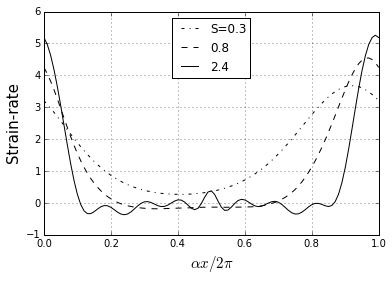

In [129]:
aLow = 1.5; aMid=4.; aHigh=12.
LxLow = 2.*np.pi/aLow; LxMid = 2.*np.pi/aMid; LxHigh = 2.*np.pi/aHigh
xArrLow = np.arange(0.,LxLow*1.001,0.01*LxLow)
xArrMid = np.arange(0.,LxMid*1.001,0.01*LxMid)
xArrHigh = np.arange(0.,LxHigh*1.001,0.01*LxHigh)

strainRateLow = shearDictLow['strainRateFun'](xArrLow)
strainRateMid = shearDictMid['strainRateFun'](xArrMid)
strainRateHigh = shearDictHigh['strainRateFun'](xArrHigh)

plt.figure()
plt.plot(np.arange(0.,1.001,0.01), strainRateLow,'k-.')
plt.plot(np.arange(0.,1.001,0.01), strainRateMid,'k--')
plt.plot(np.arange(0.,1.001,0.01), strainRateHigh,'k')
plt.grid()
plt.legend(['S=0.3','0.8','2.4'],loc='upper center')
plt.savefig(figureFolder+'noLabels/'+'localStrainRate.eps',dpi=600,format='eps')
plt.xlabel('$\\alpha x/2\\pi$',fontsize=15); plt.ylabel('Strain-rate',fontsize=15)
plt.savefig(figureFolder+'localStrainRate.eps',dpi=1200,format='eps')
plt.show()


## Re-dependence

In [3]:
import sys
epsArr = 0.5*np.array([0.05,0.15])
gArr = 0.5*np.array([0.5])
ReArr = (10.**(np.arange(0.,3.1,0.5)))
savePath = 'solutions/ReDep/'

flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0.025],'beta':0.,'Re':10.,'isPois':1,'L':8,'M':0,'N':50,'nd':3})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()

for eps in epsArr:
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for g in gArr:
        a = g/eps
        vf.flowDict.update({'alpha':a}); pf.flowDict.update({'alpha':a})
        for Re in ReArr:
            Re = round(Re,0)
            print('(eps,g,Re):',(eps,g,Re))
            vf.flowDict.update({'Re':Re}); pf.flowDict.update({'Re':Re})
            vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=8, tol= 1.0e-12)
            saveff(vf,pf,prefix=savePath)
            sys.stdout.flush()

(eps,g,Re): (0.025000000000000001, 0.25, 1.0)
Converged in  3  iterations. Returning....................................
saved to  solutions/ReDep/T00E0250Gx0250Gz0000Re0001L08M00N50
(eps,g,Re): (0.025000000000000001, 0.25, 3.0)
Converged in  2  iterations. Returning....................................
saved to  solutions/ReDep/T00E0250Gx0250Gz0000Re0003L08M00N50
(eps,g,Re): (0.025000000000000001, 0.25, 10.0)
Converged in  2  iterations. Returning....................................
saved to  solutions/ReDep/T00E0250Gx0250Gz0000Re0010L08M00N50
(eps,g,Re): (0.025000000000000001, 0.25, 32.0)
Converged in  3  iterations. Returning....................................
saved to  solutions/ReDep/T00E0250Gx0250Gz0000Re0032L08M00N50
(eps,g,Re): (0.025000000000000001, 0.25, 100.0)
Converged in  3  iterations. Returning....................................
saved to  solutions/ReDep/T00E0250Gx0250Gz0000Re0100L08M00N50
(eps,g,Re): (0.025000000000000001, 0.25, 316.0)
Converged in  3  iterations. Retu

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [3]:
loadPath = 'solutions/ReDep/'
files = os.listdir(loadPath)
files.sort()
vfList = []; pfList = []
for fName in files:
    vf,pf = loadff(loadPath+fName)
    vfList.append(vf); pfList.append(pf)

vfArr = flowFieldArray(vfList,2,len(vfList)//14,7); pfArr = flowFieldArray(pfList, 2,len(pfList)//14,7)
UbArr = vfArr.getProperty('flux')
epsArr = vfArr.getProperty('eps')
ReArr = vfArr.getProperty('Re')
gArr = vfArr.getProperty('g')
aArr = gArr/epsArr

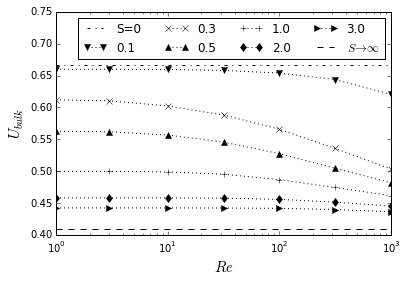

In [13]:
eInd = 1; fName= 'UbReDepE075.eps'
markers=['v','x','^','+','d','>']
upBound = 2./3.
lowBound = 2./3.*(1.-2.*epsArr[eInd,0,0])**3
plt.figure()
leg = []
plt.plot(ReArr[eInd,0,:], upBound*np.ones(ReArr.shape[2]),'k-.'); leg.append("S=0")
for k in range(6):
    plt.plot(ReArr[eInd,k], UbArr[eInd,k],'k:',marker=markers[k]); leg.append(2.*gArr[eInd,k,0])
plt.plot(ReArr[eInd,k], lowBound*np.ones(ReArr.shape[2]),'k--'); leg.append("$S \\to \\infty$")

#plt.legend([2.*gArr[eInd,:5,0],"flat","$g \to \infty$"],loc='upper right',ncol=2)

plt.legend(leg,loc='upper right',ncol=4)
plt.xscale("log")
plt.ylim([0.4,0.75])

plt.savefig(figureFolder+'noLabels/'+fName, dpi=1200,format='eps')
plt.ylabel("$U_{bulk}$",fontsize=15); plt.xlabel("$Re$",fontsize=15)
plt.savefig(figureFolder+fName, dpi=1200,format='eps')
plt.show()

In [34]:
gArr[1,0]

array([ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05])